## Fine-tune Gemma 7B it for Sentiment Analysis

For this hands-on tutorial on fine-tuning a Gemma 7B it, we are going to deal with a sentiment analysis on financial and economic information. Sentiment analysis on financial and economic information is highly relevant for businesses for several key reasons, ranging from market insights (gain valuable insights into market trends, investor confidence, and consumer behavior) to risk management (identifying potential reputational risks) to investment decisions (gauging the sentiment of stakeholders, investors, and the general public businesses can assess the potential success of various investment opportunities).

Before the technicalities of fine-tuning a large language model like Gemma, we had to find the correct dataset to demonstrate the potentialities of fine-tuning.

Particularly within the realm of finance and economic texts, annotated datasets are notably rare, with many being exclusively reserved for proprietary purposes. To address the issue of insufficient training data, scholars from the Aalto University School
of Business introduced in 2014 a set of approximately 5000 sentences. This collection aimed to establish human-annotated benchmarks, serving as a standard for evaluating alternative modeling techniques. The involved annotators (16 people with
adequate background knowledge on financial markets) were instructed to assess the sentences solely from the perspective of an investor, evaluating whether the news potentially holds a positive, negative, or neutral impact on the stock price.

The FinancialPhraseBank dataset is a comprehensive collection that captures the sentiments of financial news headlines from the viewpoint of a retail investor. Comprising two key columns, namely "Sentiment" and "News Headline," the dataset effectively classifies sentiments as either negative, neutral, or positive. This structured dataset serves as a valuable resource for analyzing and understanding the complex dynamics of sentiment in the domain of financial news. It has been used in various studies and research initiatives, since its inception in the work by Malo, P., Sinha, A., Korhonen, P., Wallenius, J., and Takala, P.  "Good debt or bad debt: Detecting semantic orientations in economic texts.", published in the Journal of the Association for Information Science and Technology in 2014.

As a first step, we install the specific libraries necessary to make this example work.

* accelerate is a distributed training library for PyTorch by HuggingFace. It allows you to train your models on multiple GPUs or CPUs in parallel (distributed configurations), which can significantly speed up training in presence of multiple GPUs (we won't use it in our example).
* peft is a Python library by HuggingFace for efficient adaptation of pre-trained language models (PLMs) to various downstream applications without fine-tuning all the model's parameters. PEFT methods only fine-tune a small number of (extra) model parameters, thereby greatly decreasing the computational and storage costs.
* bitsandbytes by Tim Dettmers, is a lightweight wrapper around CUDA custom functions, in particular 8-bit optimizers, matrix multiplication (LLM.int8()), and quantization functions. It allows to run models stored in 4-bit precision: while 4-bit bitsandbytes stores weights in 4-bits, the computation still happens in 16 or 32-bit and here any combination can be chosen (float16, bfloat16, float32, and so on).
* transformers is a Python library for natural language processing (NLP). It provides a number of pre-trained models for NLP tasks such as text classification, question answering, and machine translation.
* trl is a full stack library by HuggingFace providing a set of tools to train transformer language models with Reinforcement Learning, from the Supervised Fine-tuning step (SFT), Reward Modeling step (RM) to the Proximal Policy Optimization (PPO) step.

In [1]:
!pip install -q -U torch --index-url https://download.pytorch.org/whl/cu117

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 594.2 kB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 13.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 8.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytorch-lightning 2.5.1.post0 requires torch>=2.1.0, but you have torch 2.0.1+cu117 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.0.1+cu117 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.0.1+cu117 which is incompatible.


In [2]:
!pip install -q -U transformers==4.38.2
!pip install -q accelerate==0.26.1
!pip install -q -i https://pypi.org/simple/ bitsandbytes
!pip install -q -U datasets==2.16.1
!pip install -q -U trl==0.7.11
!pip install -q -U peft==0.8.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.7/130.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 102.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 89.0 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.4.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.38.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 25.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 2.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 4.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 101.4 MB/s eta 0:00:0000:0100:01
   ━━━━━

The code imports the os module and sets two environment variables:
* CUDA_VISIBLE_DEVICES: This environment variable tells PyTorch which GPUs to use. In this case, the code is setting the environment variable to 0, which means that PyTorch will use the first GPU.
* TOKENIZERS_PARALLELISM: This environment variable tells the Hugging Face Transformers library whether to parallelize the tokenization process. In this case, the code is setting the environment variable to false, which means that the tokenization process will not be parallelized.

In [9]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [10]:
print("Previous block executed successfully!")

Previous block executed successfully!


The code import warnings; warnings.filterwarnings("ignore") imports the warnings module and sets the warning filter to ignore. This means that all warnings will be suppressed and will not be displayed. Actually during training there are many warnings that do not prevent the fine-tuning but can be distracting and make you wonder if you are doing the correct things.

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
print("Previous block executed successfully!")

Previous block executed successfully!


In the following cell there are all the other imports for running the notebook

In [15]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

import torch
import torch.nn as nn

import transformers
from transformers import (AutoModelForCausalLM, 
                          AutoTokenizer, 
                          BitsAndBytesConfig, 
                          TrainingArguments, 
                          pipeline, 
                          logging)
from datasets import Dataset
from peft import LoraConfig, PeftConfig
import bitsandbytes as bnb
from trl import SFTTrainer

from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix)
from sklearn.model_selection import train_test_split

2025-06-20 16:26:04.216170: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750436764.448385      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750436764.518757      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [16]:
print(f"transformers=={transformers.__version__}")

transformers==4.38.2


As a first step we need to take care of the model, which is a 7b-v0.1-hf (7 billion parameters, version 0.1, in the HuggingFace compatible format), loading from Kaggle models and quantization.

Model loading and quantization:

* First the code loads the Gemma 7B it language model from the Hugging Face Hub.
* Then the code gets the float16 data type from the torch library. This is the data type that will be used for the computations.
* Next, it creates a BitsAndBytesConfig object with the following settings:
    1. load_in_4bit: Load the model weights in 4-bit format.
    2. bnb_4bit_quant_type: Use the "nf4" quantization type. 4-bit NormalFloat (NF4), is a new data type that is information theoretically optimal for normally distributed weights.
    3. bnb_4bit_compute_dtype: Use the float16 data type for computations.
    4. bnb_4bit_use_double_quant: Do not use double quantization (reduces the average memory footprint by quantizing also the quantization constants and saves an additional 0.4 bits per parameter.).
* Then the code creates a AutoModelForCausalLM object from the pre-trained Gemma 7B it language model, using the BitsAndBytesConfig object for quantization.
* After that, the code disables caching for the model.
* Finally the code sets the pre-training token probability to 1.

Tokenizer loading:

* First, the code loads the tokenizer for the Gemma 7B it language model.
* Then it sets the padding token to be the end-of-sequence (EOS) token.
* Finally, the code sets the padding side to be "left", which means that the input sequences will be padded on the left side.

In [26]:

model_name = "google/gemma-7b-it" 

compute_dtype = getattr(torch, "float16")

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=False,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config=bnb_config,
)

model.config.use_cache = False
model.config.pretraining_tp = 1

max_seq_length = 2048
tokenizer = AutoTokenizer.from_pretrained(model_name, max_seq_length=max_seq_length)
EOS_TOKEN = tokenizer.eos_token

config.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/20.9k [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/2.11G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/34.2k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.24M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

The code in the next cell performs the following steps:

1. Reads the input dataset from the all-data.csv file, which is a comma-separated value (CSV) file with two columns: sentiment and text.
2. Splits the dataset into training and test sets, with 300 samples in each set. The split is stratified by sentiment, so that each set contains a representative sample of positive, neutral, and negative sentiments.
3. Shuffles the train data in a replicable order (random_state=10)
4. Transforms the texts contained in the train and test data into prompts to be used by Gemma: the train prompts contains the expected answer we want to fine-tune the model with
5. The residual examples not in train or test, for reporting purposes during training (but it won't be used for early stopping), is treated as evaluation data, which is sampled with repetition in order to have a 50/50/50 sample (negative instances are very few, hence they should be repeated)
5. The train and eval data are wrapped by the class from Hugging Face (https://huggingface.co/docs/datasets/index)

This prepares in a single cell train_data, eval_data and test_data datasets to be used in our fine tuning.

In [28]:
filename = "../input/sentiment-analysis-for-financial-news/all-data.csv"

df = pd.read_csv(filename, 
                 names=["sentiment", "text"],
                 encoding="utf-8", encoding_errors="replace")

X_train = list()
X_test = list()
for sentiment in ["positive", "neutral", "negative"]:
    train, test  = train_test_split(df[df.sentiment==sentiment], 
                                    train_size=300,
                                    test_size=300, 
                                    random_state=42)
    X_train.append(train)
    X_test.append(test)

X_train = pd.concat(X_train).sample(frac=1, random_state=10)
X_test = pd.concat(X_test)

eval_idx = [idx for idx in df.index if idx not in list(train.index) + list(test.index)]
X_eval = df[df.index.isin(eval_idx)]
X_eval = (X_eval
          .groupby('sentiment', group_keys=False)
          .apply(lambda x: x.sample(n=50, random_state=10, replace=True)))
X_train = X_train.reset_index(drop=True)

def generate_prompt(data_point):
    return f"""generate_prompt
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative"

            [{data_point["text"]}] = {data_point["sentiment"]}
            """.strip() + EOS_TOKEN

def generate_test_prompt(data_point):
    return f"""
            Analyze the sentiment of the news headline enclosed in square brackets, 
            determine if it is positive, neutral, or negative, and return the answer as 
            the corresponding sentiment label "positive" or "neutral" or "negative"

            [{data_point["text"]}] = 

            """.strip()

X_train = pd.DataFrame(X_train.apply(generate_prompt, axis=1), 
                       columns=["text"])
X_eval = pd.DataFrame(X_eval.apply(generate_prompt, axis=1), 
                      columns=["text"])

y_true = X_test.sentiment
X_test = pd.DataFrame(X_test.apply(generate_test_prompt, axis=1), columns=["text"])

train_data = Dataset.from_pandas(X_train)
eval_data = Dataset.from_pandas(X_eval)

In [29]:
print("X_train head:")
print(X_train.head())
print("\nX_eval head:")
print(X_eval.head())
print("\nX_test head:")
print(X_test.head())
print("\ntrain_data info:")
print(train_data)
print("\neval_data info:")
print(eval_data)
print("\ny_true value counts:")
print(y_true.value_counts())

X_train head:
                                                text
0  generate_prompt\n            Analyze the senti...
1  generate_prompt\n            Analyze the senti...
2  generate_prompt\n            Analyze the senti...
3  generate_prompt\n            Analyze the senti...
4  generate_prompt\n            Analyze the senti...

X_eval head:
                                                   text
3622  generate_prompt\n            Analyze the senti...
3622  generate_prompt\n            Analyze the senti...
3498  generate_prompt\n            Analyze the senti...
4653  generate_prompt\n            Analyze the senti...
3498  generate_prompt\n            Analyze the senti...

X_test head:
                                                   text
567   Analyze the sentiment of the news headline enc...
1752  Analyze the sentiment of the news headline enc...
995   Analyze the sentiment of the news headline enc...
601   Analyze the sentiment of the news headline enc...
568   Analyze the sentim

Next we create a function to evaluate the results from our fine-tuned sentiment model. The function performs the following steps:

1. Maps the sentiment labels to a numerical representation, where 2 represents positive, 1 represents neutral, and 0 represents negative.
2. Calculates the accuracy of the model on the test data.
3. Generates an accuracy report for each sentiment label.
4. Generates a classification report for the model.
5. Generates a confusion matrix for the model.

In [30]:
def evaluate(y_true, y_pred):
    labels = ['positive', 'neutral', 'negative']
    mapping = {'positive': 2, 'neutral': 1, 'none':1, 'negative': 0}
    def map_func(x):
        return mapping.get(x, 1)
    
    y_true = np.vectorize(map_func)(y_true)
    y_pred = np.vectorize(map_func)(y_pred)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    print(f'Accuracy: {accuracy:.3f}')
    
    # Generate accuracy report
    unique_labels = set(y_true)  # Get unique labels
    
    for label in unique_labels:
        label_indices = [i for i in range(len(y_true)) 
                         if y_true[i] == label]
        label_y_true = [y_true[i] for i in label_indices]
        label_y_pred = [y_pred[i] for i in label_indices]
        accuracy = accuracy_score(label_y_true, label_y_pred)
        print(f'Accuracy for label {label}: {accuracy:.3f}')
        
    # Generate classification report
    class_report = classification_report(y_true=y_true, y_pred=y_pred)
    print('\nClassification Report:')
    print(class_report)
    
    # Generate confusion matrix
    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=[0, 1, 2])
    print('\nConfusion Matrix:')
    print(conf_matrix)

In the next cell, we set a function for predicting the sentiment of a news headline using the Gemma 7B it language model. The function takes three arguments:

test: A Pandas DataFrame containing the news headlines to be predicted.
model: The pre-trained Gemma 7B it language model.
tokenizer: The tokenizer for the Gemma 7B it language model.

The function works as follows:

1. For each news headline in the test DataFrame:
    * Create a prompt for the language model, which asks it to analyze the sentiment of the news headline and return the corresponding sentiment label.
    * Use the pipeline() function from the Hugging Face Transformers library to generate text from the language model, using the prompt.
    * Extract the predicted sentiment label from the generated text.
    * Append the predicted sentiment label to the y_pred list.
2. Return the y_pred list.

The pipeline() function from the Hugging Face Transformers library is used to generate text from the language model. The task argument specifies that the task is text generation. The model and tokenizer arguments specify the pre-trained Gemma 7B it language model and the tokenizer for the language model. The max_new_tokens argument specifies the maximum number of new tokens to generate. The temperature argument controls the randomness of the generated text. A lower temperature will produce more predictable text, while a higher temperature will produce more creative and unexpected text.

The if statement checks if the generated text contains the word "positive". If it does, then the predicted sentiment label is "positive". Otherwise, the if statement checks if the generated text contains the word "negative". If it does, then the predicted sentiment label is "negative". Otherwise, the if statement checks if the generated text contains the word "neutral". If it does, then the predicted sentiment label is "neutral.

In [31]:
def predict(X_test, model, tokenizer):
    y_pred = []
    for i in tqdm(range(len(X_test))):
        prompt = X_test.iloc[i]["text"]
        input_ids = tokenizer(prompt, return_tensors="pt").to("cuda")
        outputs = model.generate(**input_ids, max_new_tokens=1, temperature=0.0)
        result = tokenizer.decode(outputs[0])
        answer = result.split("=")[-1].lower()
        if "positive" in answer:
            y_pred.append("positive")
        elif "negative" in answer:
            y_pred.append("negative")
        elif "neutral" in answer:
            y_pred.append("neutral")
        else:
            y_pred.append("none")
    return y_pred

At this point, we are ready to test the Gemma 7B it model and see how it performs on our problem without any fine-tuning. This allows us to get insights on the model itself and establish a baseline.

In [32]:
y_pred = predict(X_test, model, tokenizer)

100%|██████████| 900/900 [06:26<00:00,  2.33it/s]


In the following cell, we evaluate the results. There is little to be said, it is performing really terribly because the 7b-hf model tends to just predict a neutral sentiment and seldom it detects positive or negative sentiment.

In [33]:
evaluate(y_true, y_pred)

Accuracy: 0.632
Accuracy for label 0: 0.807
Accuracy for label 1: 0.193
Accuracy for label 2: 0.897

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.81      0.87       300
           1       0.46      0.19      0.27       300
           2       0.52      0.90      0.66       300

    accuracy                           0.63       900
   macro avg       0.64      0.63      0.60       900
weighted avg       0.64      0.63      0.60       900


Confusion Matrix:
[[242  41  17]
 [ 13  58 229]
 [  4  27 269]]


In the next cell we set everything ready for the fine-tuning. We configures and initializes a Simple Fine-tuning Trainer (SFTTrainer) for training a large language model using the Parameter-Efficient Fine-Tuning (PEFT) method, which should save time as it operates on a reduced number of parameters compared to the model's overall size. The PEFT method focuses on refining a limited set of (additional) model parameters, while keeping the majority of the pre-trained LLM parameters fixed. This significantly reduces both computational and storage expenses. Additionally, this strategy addresses the challenge of catastrophic forgetting, which often occurs during the complete fine-tuning of LLMs.

PEFTConfig:

The peft_config object specifies the parameters for PEFT. The following are some of the most important parameters:

* lora_alpha: The learning rate for the LoRA update matrices.
* lora_dropout: The dropout probability for the LoRA update matrices.
* r: The rank of the LoRA update matrices.
* bias: The type of bias to use. The possible values are none, additive, and learned.
* task_type: The type of task that the model is being trained for. The possible values are CAUSAL_LM and MASKED_LM.

TrainingArguments:

The training_arguments object specifies the parameters for training the model. The following are some of the most important parameters:

* output_dir: The directory where the training logs and checkpoints will be saved.
* num_train_epochs: The number of epochs to train the model for.
* per_device_train_batch_size: The number of samples in each batch on each device.
* gradient_accumulation_steps: The number of batches to accumulate gradients before updating the model parameters.
* gradient_checkpointing: use less GPU memory at the cost of small decrease in the training speed due to graph recomputing
* optim: The optimizer to use for training the model.
* save_steps: The number of steps after which to save a checkpoint.
* logging_steps: The number of steps after which to log the training metrics.
* learning_rate: The learning rate for the optimizer.
* weight_decay: The weight decay parameter for the optimizer.
* fp16: Whether to use 16-bit floating-point precision.
* bf16: Whether to use BFloat16 precision.
* max_grad_norm: The maximum gradient norm.
* max_steps: The maximum number of steps to train the model for.
* warmup_ratio: The proportion of the training steps to use for warming up the learning rate.
* group_by_length: Whether to group the training samples by length.
* lr_scheduler_type: The type of learning rate scheduler to use.
* report_to: The tools to report the training metrics to.
* evaluation_strategy: The strategy for evaluating the model during training.
* eval_steps: Number of update steps between two evaluations
* eval_accumulation_steps: Number of predictions steps to accumulate the output tensors for, before moving to the CPU

SFTTrainer:

The SFTTrainer is a custom trainer class from the TRL library. It is used to train large language models using the PEFT method.

The SFTTrainer object is initialized with the following arguments:

* model: The model to be trained.
* train_dataset: The training dataset.
* eval_dataset: The evaluation dataset.
* peft_config: The PEFT configuration.
* dataset_text_field: The name of the text field in the dataset.
* tokenizer: The tokenizer to use.
* args: The training arguments.
* packing: Whether to pack the training samples.
* max_seq_length: The maximum sequence length.

Once the SFTTrainer object is initialized, it can be used to train the model by calling the train() method

In [34]:
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0,
    r=64,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj",],
)

training_arguments = TrainingArguments(
    output_dir="logs",
    num_train_epochs=5,
    gradient_checkpointing=True,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=8,
    optim="paged_adamw_32bit",
    save_steps=0,
    logging_steps=25,
    learning_rate=2e-4,
    weight_decay=0.001,
    fp16=True,
    bf16=False,
    max_grad_norm=0.3,
    max_steps=-1,
    warmup_ratio=0.03,
    group_by_length=False,
    evaluation_strategy='steps',
    eval_steps = 112,
    eval_accumulation_steps=1,
    lr_scheduler_type="cosine",
    report_to="tensorboard",
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=eval_data,
    peft_config=peft_config,
    dataset_text_field="text",
    tokenizer=tokenizer,
    max_seq_length=max_seq_length,
    args=training_arguments,
    packing=False,
)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

The following code will train the model using the trainer.train() method and then save the trained model to the trained-model directory. Using The standard GPU P100 offered by Kaggle, the training should be quite fast.

In [35]:
# Train model
trainer.train()

# Save trained model
trainer.model.save_pretrained("trained-model")

Step,Training Loss,Validation Loss
112,0.839100,1.508379
224,0.598600,1.469771
336,0.347100,1.598299
448,0.190900,1.887054
560,0.128000,2.022113


Afterwards, loading the TensorBoard extension and start TensorBoard, pointing to the logs/runs directory, which is assumed to contain the training logs and checkpoints for your model, will allow you to understand how the models fits during the training.

In [53]:
%load_ext tensorboard
%tensorboard --logdir logs/runs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [52]:
 !kill 261

The following code will first predict the sentiment labels for the test set using the predict() function. Then, it will evaluate the model's performance on the test set using the evaluate() function. The result now should be impressive with an overall accuracy of over 0.8 and high accuracy, precision and recall for the single sentiment labels. The prediction of the neutral label can still be improved, yet it is impressive how much could be done with little data and some fine-tuning.

In [54]:
y_pred = predict(X_test, model, tokenizer)
evaluate(y_true, y_pred)

100%|██████████| 900/900 [07:00<00:00,  2.14it/s]

Accuracy: 0.883
Accuracy for label 0: 0.953
Accuracy for label 1: 0.873
Accuracy for label 2: 0.823

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.96       300
           1       0.80      0.87      0.84       300
           2       0.89      0.82      0.86       300

    accuracy                           0.88       900
   macro avg       0.89      0.88      0.88       900
weighted avg       0.89      0.88      0.88       900


Confusion Matrix:
[[286  12   2]
 [ 10 262  28]
 [  1  52 247]]


The following code will create a Pandas DataFrame called evaluation containing the text, true labels, and predicted labels from the test set. This is expectially useful for understanding the errors that the fine-tuned model makes, and gettting insights on how to improve the prompt.

In [55]:
evaluation = pd.DataFrame({'text': X_test["text"], 
                           'y_true':y_true, 
                           'y_pred': y_pred},
                         )
evaluation.to_csv("test_predictions.csv", index=False)

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

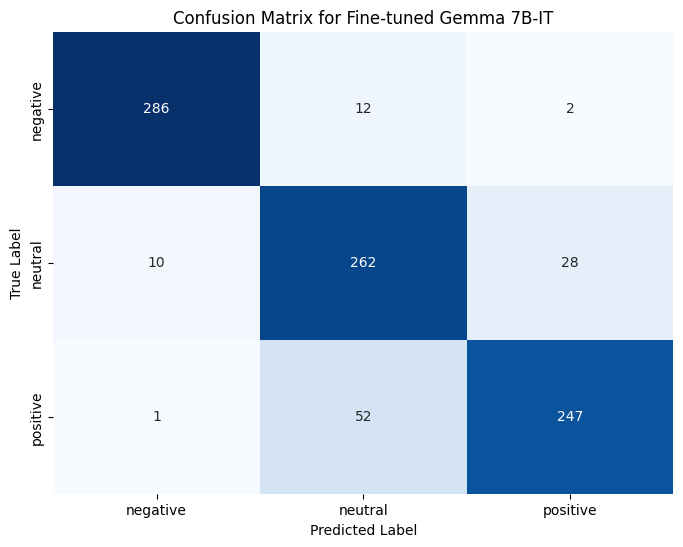


Raw Confusion Matrix (Numerical):
[[286  12   2]
 [ 10 262  28]
 [  1  52 247]]


In [59]:
# Define the mapping and labels as they were used in your evaluate function
mapping = {'positive': 2, 'neutral': 1, 'none': 1, 'negative': 0}
labels = ['negative', 'neutral', 'positive']

# Convert y_true and y_pred to numerical format using the mapping
def map_func_for_plot(x):
    return mapping.get(x, 1) 

y_true_mapped = np.vectorize(map_func_for_plot)(y_true)
y_pred_mapped = np.vectorize(map_func_for_plot)(y_pred)

# Generate the confusion matrix
cm = confusion_matrix(y_true=y_true_mapped, y_pred=y_pred_mapped, labels=[0, 1, 2])

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Fine-tuned Gemma 7B-IT')

# SAVE THE PLOT 
plt.savefig('confusion_matrix_gemma_finetuned.png', dpi=300, bbox_inches='tight')


plt.show() 

# Print raw confusion matrix for verification
print("\nRaw Confusion Matrix (Numerical):")
print(cm)

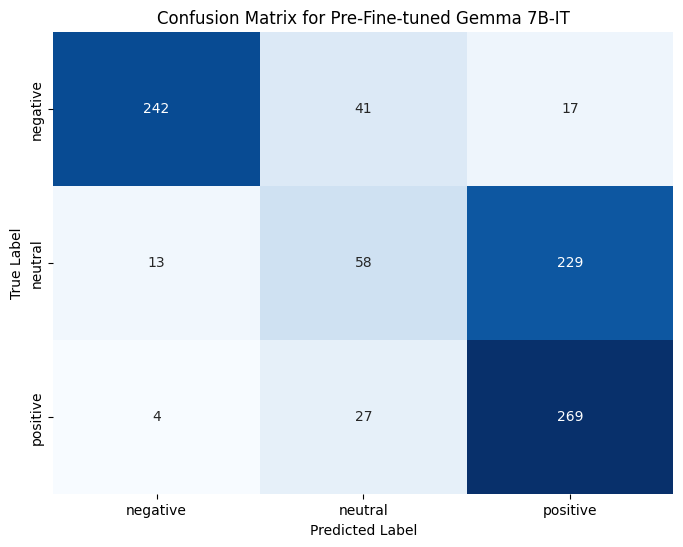


Raw Confusion Matrix (Pre-Fine-tuned):
[[242  41  17]
 [ 13  58 229]
 [  4  27 269]]


In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Define the numerical confusion matrix from the first evaluation (before fine-tuning)

cm_pre_finetune = np.array([
    [242, 41, 17],
    [13, 58, 229],
    [4, 27, 269]
])

# Define the labels (order matters: 0=negative, 1=neutral, 2=positive)
labels = ['negative', 'neutral', 'positive']

# Plot the pre-fine-tuned confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_pre_finetune, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Pre-Fine-tuned Gemma 7B-IT')

# Save the plot
plt.savefig('confusion_matrix_gemma_pre_finetuned.png', dpi=300, bbox_inches='tight')

plt.show()

print("\nRaw Confusion Matrix (Pre-Fine-tuned):")
print(cm_pre_finetune)

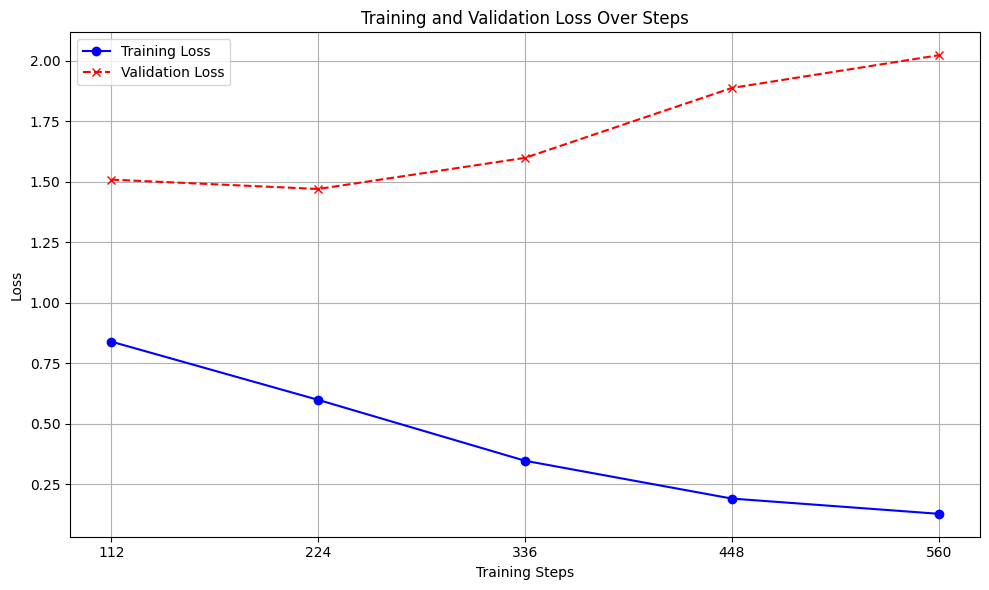

In [61]:
import matplotlib.pyplot as plt
import numpy as np

# Data from your training logs
steps = np.array([112, 224, 336, 448, 560])
training_losses = np.array([0.839100, 0.598600, 0.347100, 0.190900, 0.128000])
validation_losses = np.array([1.508379, 1.469771, 1.598299, 1.887054, 2.022113])

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(steps, training_losses, label='Training Loss', marker='o', linestyle='-', color='blue')
plt.plot(steps, validation_losses, label='Validation Loss', marker='x', linestyle='--', color='red')

# Add labels and title
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Steps')
plt.xticks(steps) 
plt.grid(True)
plt.legend()
plt.tight_layout()

# Save the plot
plt.savefig('training_validation_loss_plot.png', dpi=300, bbox_inches='tight')

plt.show()

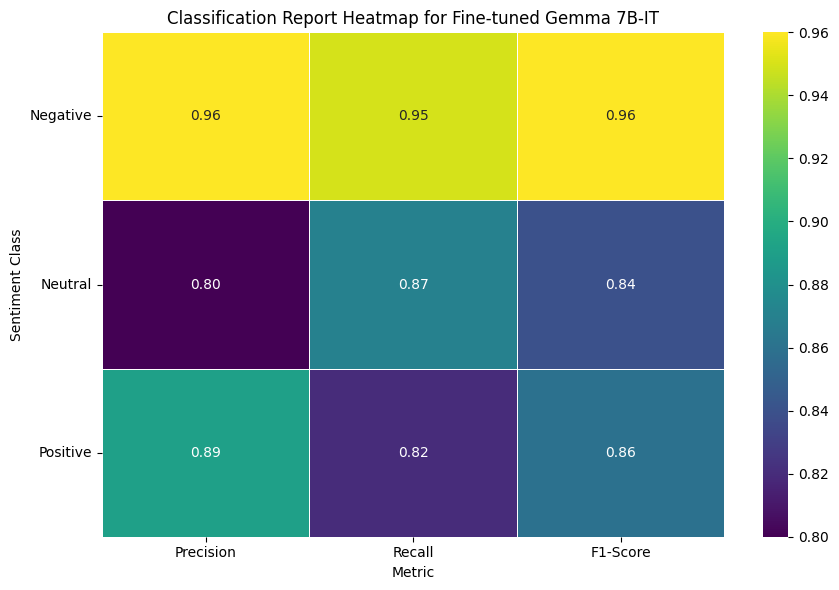

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Import pandas to create the DataFrame

# Data from your fine-tuned model's classification report
metrics_data = {
    'Precision': [0.96, 0.80, 0.89],
    'Recall': [0.95, 0.87, 0.82],
    'F1-Score': [0.96, 0.84, 0.86]
}
labels = ['Negative', 'Neutral', 'Positive'] # Match the order of your metrics

df_metrics = pd.DataFrame(metrics_data, index=labels)

# Plotting the heatmap
plt.figure(figsize=(9, 6))
sns.heatmap(df_metrics, annot=True, cmap='viridis', fmt=".2f", linewidths=.5)
plt.title('Classification Report Heatmap for Fine-tuned Gemma 7B-IT')
plt.ylabel('Sentiment Class')
plt.xlabel('Metric')
plt.yticks(rotation=0)
plt.tight_layout()

# Save the plot
plt.savefig('classification_report_heatmap_finetuned.png', dpi=300, bbox_inches='tight')

plt.show()

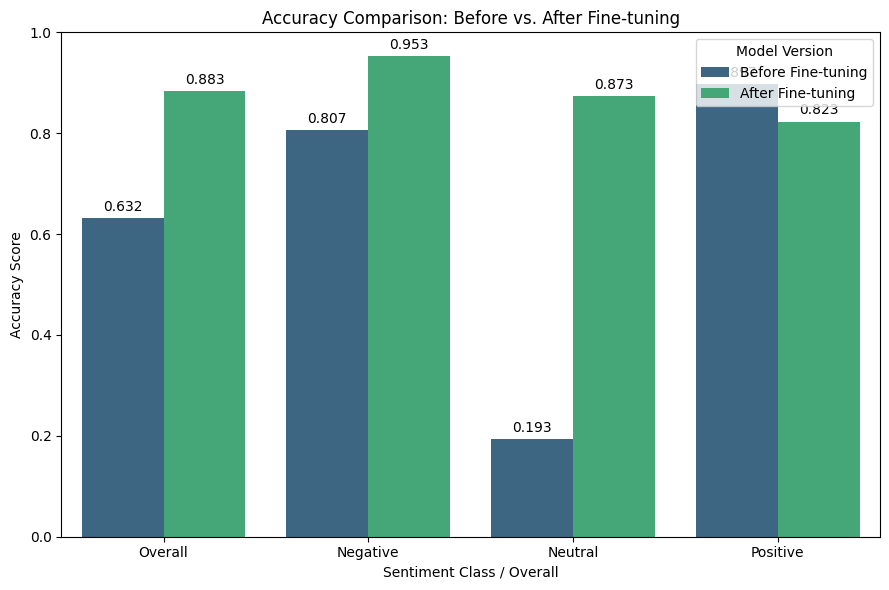

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data for Accuracy comparison
accuracy_data = {
    'Class': ['Overall', 'Negative', 'Neutral', 'Positive'],
    'Before Fine-tuning': [0.632, 0.807, 0.193, 0.897],
    'After Fine-tuning': [0.883, 0.953, 0.873, 0.823]
}

df_accuracy = pd.DataFrame(accuracy_data)

# Melt the DataFrame for seaborn
df_accuracy_melted = df_accuracy.melt(id_vars='Class', var_name='Model Version', value_name='Accuracy')

# Create the plot
plt.figure(figsize=(9, 6))
sns.barplot(x='Class', y='Accuracy', hue='Model Version', data=df_accuracy_melted, palette='viridis')

# Add labels and title
plt.xlabel('Sentiment Class / Overall')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Comparison: Before vs. After Fine-tuning')
plt.ylim(0, 1) # Accuracy scores are between 0 and 1

# Add value labels on top of the bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.3f', label_type='edge', padding=3)

plt.tight_layout()

# Save the plot
plt.savefig('accuracy_comparison_bar_chart.png', dpi=300, bbox_inches='tight')

plt.show()

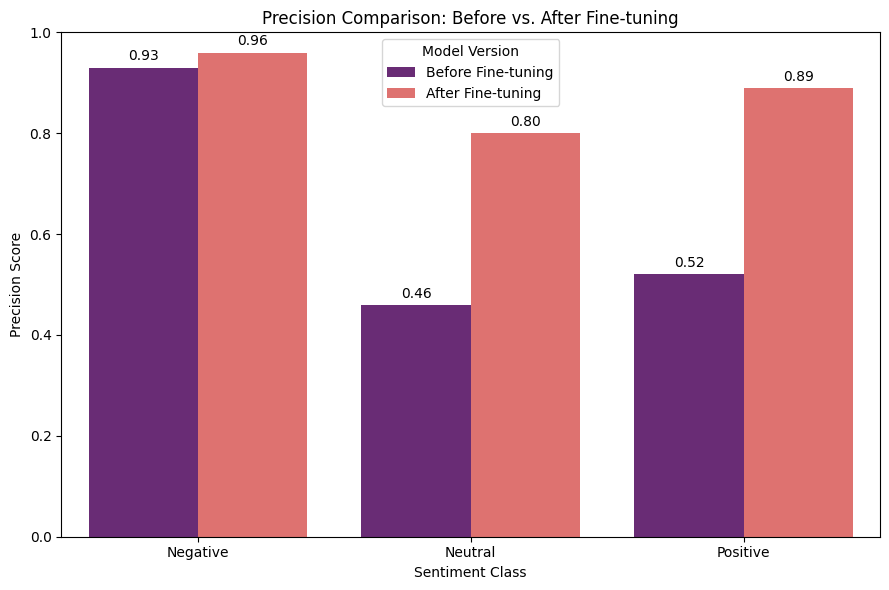

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data for Precision comparison
precision_data = {
    'Class': ['Negative', 'Neutral', 'Positive'],
    'Before Fine-tuning': [0.93, 0.46, 0.52],
    'After Fine-tuning': [0.96, 0.80, 0.89]
}

df_precision = pd.DataFrame(precision_data)

# Melt the DataFrame for seaborn
df_precision_melted = df_precision.melt(id_vars='Class', var_name='Model Version', value_name='Precision')

# Create the plot
plt.figure(figsize=(9, 6))
sns.barplot(x='Class', y='Precision', hue='Model Version', data=df_precision_melted, palette='magma')

# Add labels and title
plt.xlabel('Sentiment Class')
plt.ylabel('Precision Score')
plt.title('Precision Comparison: Before vs. After Fine-tuning')
plt.ylim(0, 1) # Precision scores are between 0 and 1

# Add value labels on top of the bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()

# Save the plot
plt.savefig('precision_comparison_bar_chart.png', dpi=300, bbox_inches='tight')

plt.show()

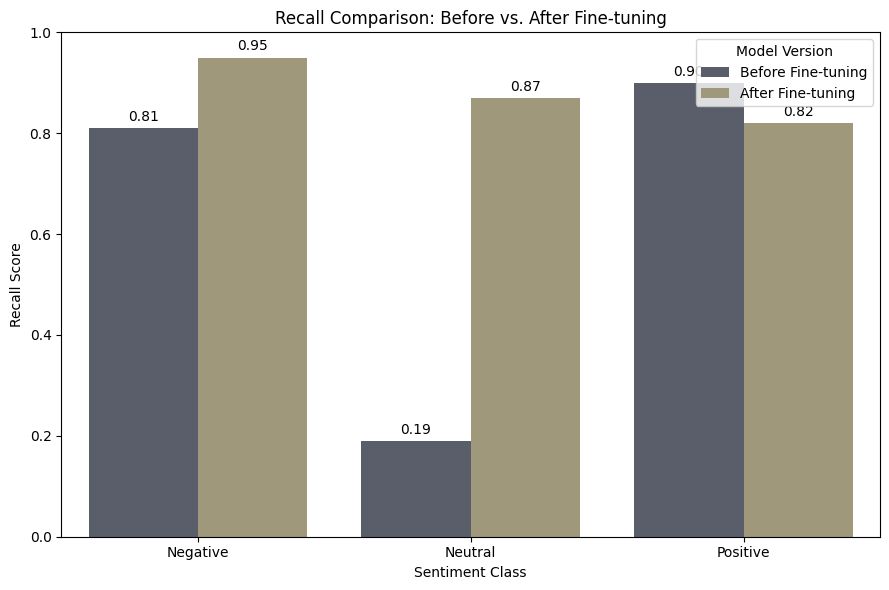

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data for Recall comparison
recall_data = {
    'Class': ['Negative', 'Neutral', 'Positive'],
    'Before Fine-tuning': [0.81, 0.19, 0.90],
    'After Fine-tuning': [0.95, 0.87, 0.82]
}

df_recall = pd.DataFrame(recall_data)

# Melt the DataFrame for seaborn
df_recall_melted = df_recall.melt(id_vars='Class', var_name='Model Version', value_name='Recall')

# Create the plot
plt.figure(figsize=(9, 6))
sns.barplot(x='Class', y='Recall', hue='Model Version', data=df_recall_melted, palette='cividis')

# Add labels and title
plt.xlabel('Sentiment Class')
plt.ylabel('Recall Score')
plt.title('Recall Comparison: Before vs. After Fine-tuning')
plt.ylim(0, 1) # Recall scores are between 0 and 1

# Add value labels on top of the bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()

# Save the plot
plt.savefig('recall_comparison_bar_chart.png', dpi=300, bbox_inches='tight')

plt.show()

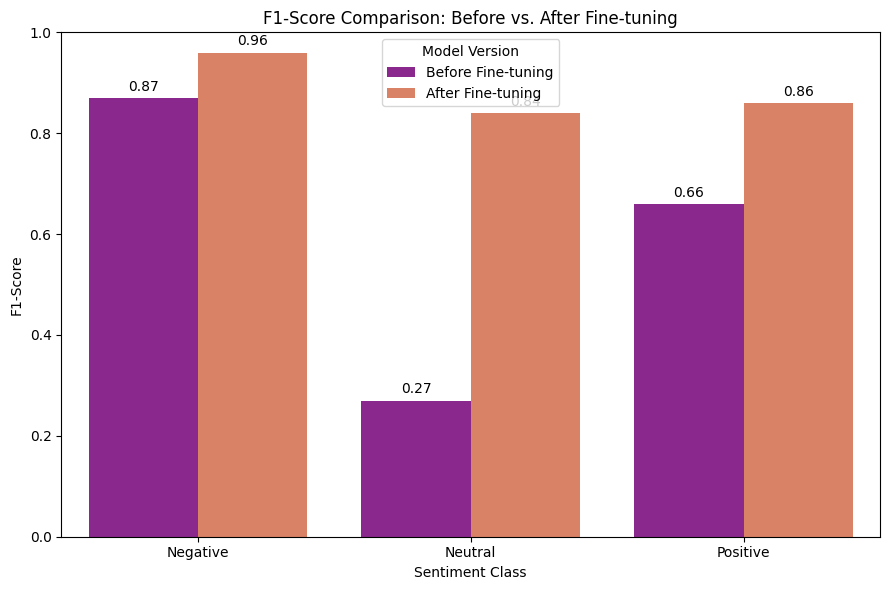

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Data for F1-Score comparison
f1_data = {
    'Class': ['Negative', 'Neutral', 'Positive'],
    'Before Fine-tuning': [0.87, 0.27, 0.66],
    'After Fine-tuning': [0.96, 0.84, 0.86]
}

df_f1 = pd.DataFrame(f1_data)

# Melt the DataFrame for seaborn
df_f1_melted = df_f1.melt(id_vars='Class', var_name='Model Version', value_name='F1-Score')

# Create the plot
plt.figure(figsize=(9, 6))
sns.barplot(x='Class', y='F1-Score', hue='Model Version', data=df_f1_melted, palette='plasma')

# Add labels and title
plt.xlabel('Sentiment Class')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison: Before vs. After Fine-tuning')
plt.ylim(0, 1) # F1-Score scores are between 0 and 1

# Add value labels on top of the bars
for container in plt.gca().containers:
    plt.bar_label(container, fmt='%.2f', label_type='edge', padding=3)

plt.tight_layout()

# Save the plot
plt.savefig('f1_score_comparison_bar_chart.png', dpi=300, bbox_inches='tight')

plt.show()

In [69]:
import pandas as pd

# Data for the comprehensive performance metrics table
performance_data = {
    "Metric": [
        "Accuracy",
        "Precision", "Recall", "F1-Score",
        "Precision", "Recall", "F1-Score",
        "Precision", "Recall", "F1-Score"
    ],
    "Class": [
        "Overall",
        "Negative", "Negative", "Negative",
        "Neutral", "Neutral", "Neutral",
        "Positive", "Positive", "Positive"
    ],
    "Before Fine-tuning": [
        0.632,
        0.93, 0.81, 0.87,
        0.46, 0.19, 0.27,
        0.52, 0.90, 0.66
    ],
    "After Fine-tuning": [
        0.883,
        0.96, 0.95, 0.96,
        0.80, 0.87, 0.84,
        0.89, 0.82, 0.86
    ]
}

df_performance = pd.DataFrame(performance_data)

print("--- Performance Metrics Comparison Table ---")
# Using to_string() with float_format for consistent decimal places
print(df_performance.to_string(index=False, float_format="%.3f"))
print("\n")

--- Performance Metrics Comparison Table ---
   Metric    Class  Before Fine-tuning  After Fine-tuning
 Accuracy  Overall               0.632              0.883
Precision Negative               0.930              0.960
   Recall Negative               0.810              0.950
 F1-Score Negative               0.870              0.960
Precision  Neutral               0.460              0.800
   Recall  Neutral               0.190              0.870
 F1-Score  Neutral               0.270              0.840
Precision Positive               0.520              0.890
   Recall Positive               0.900              0.820
 F1-Score Positive               0.660              0.860


